In [1]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/MSc_Thesis/'

import os
os.chdir(project_path)

Mounted at /content/drive


In [ ]:
import numpy as np
from utils.helpers_functions import denormalize_mae, read_dataset,mean_with_land_mask, mean_with_coastline_mask
from utils.display_functions import plot_to_compare, plot_history, plot_per_pixel_metrics, plot_degrees_mae, plot_mask_grid
from utils.models_functions import psnr, ssim, load_model, save_model, train_model
from utils.evaluation_functions import evaluate_per_pixel

dates_path='input_data/index/'
lr_data_path='input_data/deg/1x1/'
hr_data_path='input_data/deg/0_5x0_5/'
global_mean = 286.307980744908
global_Std = 64.2568020375484
target_size = (160, 290)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Add, LeakyReLU, Lambda, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Model

# Residual Block (Keeping Filters Constant)
def residual_block(x, filters=32, kernel_size=3, scaling=0.1):
    res = Conv2D(filters, kernel_size, padding='same')(x)
    res = LeakyReLU(alpha=0.2)(res)
    res = Conv2D(filters, kernel_size, padding='same')(res)
    res = Lambda(lambda t: t * scaling)(res)  # Scale residual output
    return Add()([x, res])  # Skip connection within residual block

def create_edsr():
    input_img = Input(shape=(80, 145, 1))  # Low-resolution input

    # Initial Conv Layer
    initial_conv = Conv2D(filters=32, kernel_size=3, padding='same')(input_img)
    # x = LeakyReLU(alpha=0.2)(x)

    # Residual Blocks (Feature Extraction)
    x = residual_block(initial_conv, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)

    x = Conv2D(filters=32, kernel_size=3, padding='same')(x)

    x = Add()([x, initial_conv])

    # Upsampling Layer moved to the end
    x = UpSampling2D(size=(2, 2))(x)  # Upscale to (160, 290)

    # Final Conv Layer (Reduces to 1 Output Channel)
    output_img = Conv2D(filters=1, kernel_size=3, padding='same')(x)

    # Model Compilation
    model = Model(inputs=input_img, outputs=output_img)
    model.compile(optimizer='adam', loss='mae', metrics=[psnr, ssim, 'mse', 'mae'])

    return model

In [ ]:
trainX, valX, testX, trainY, valY, testY, trainDates, valDates, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                                         'all', 2000, 2020, global_mean, global_Std)

print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)

(21478, 80, 145, 1)
(21478, 160, 290, 1)
(4602, 80, 145, 1)
(4602, 160, 290, 1)


In [ ]:
# Initialize the model
edsr_model = create_edsr()
edsr_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 80, 145, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 80, 145, 32)    │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 80, 145, 32)    │          9,248 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 80, 145, 32)    │              0 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 80, 145, 32)    │          9,248 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 80, 145, 32)    │              0 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 80, 145, 32)    │              0 │ conv2d_11[0][0],       │
│                           │                        │                │ lambda_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 80, 145, 32)    │          9,248 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 80, 145, 32)    │              0 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 80, 145, 32)    │          9,248 │ leaky_re_lu_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 80, 145, 32)    │              0 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 80, 145, 32)    │              0 │ add_5[0][0],           │
│                           │                        │                │ lambda_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 80, 145, 32)    │          9,248 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 80, 145, 32)    │              0 │ conv2d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 80, 145, 32)    │          9,248 │ leaky_re_lu_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 80, 145, 32)    │              0 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 80, 145, 32)    │              0 │ add_6[0][0],           │
│                           │                        │                │ lambda_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)   

 Total params: 83,841 (327.50 KB)

 Trainable params: 83,841 (327.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 31s 151ms/step - loss: 0.0373 - mae: 0.0373 - mse: 0.0073 - psnr: 26.5131 - ssim: 0.8265 - val_loss: 0.0082 - val_mae: 0.0082 - val_mse: 2.8803e-04 - val_psnr: 35.4064 - val_ssim: 0.9567 - learning_rate: 0.0010
Epoch 2/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - loss: 0.0078 - mae: 0.0078 - mse: 2.5419e-04 - psnr: 35.9762 - ssim: 0.9579 - val_loss: 0.0073 - val_mae: 0.0073 - val_mse: 1.9094e-04 - val_psnr: 37.1914 - val_ssim: 0.9598 - learning_rate: 0.0010
Epoch 3/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 0.0070 - mae: 0.0070 - mse: 1.8159e-04 - psnr: 37.4118 - ssim: 0.9598 - val_loss: 0.0067 - val_mae: 0.0067 - val_mse: 1.6719e-04 - val_psnr: 37.7681 - val_ssim: 0.9605 - learning_rate: 0.0010
Epoch 4/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - loss: 0.0067 - mae: 0.0067 - mse: 1.6755e-04 - psnr: 37.7592 - ssim: 0.9606 - val_loss: 0.0065 - val_mae: 0.0065 - val_mse: 1.6348e-04 - val_psnr: 37.8657 - val_ssim: 0.9610 - learn

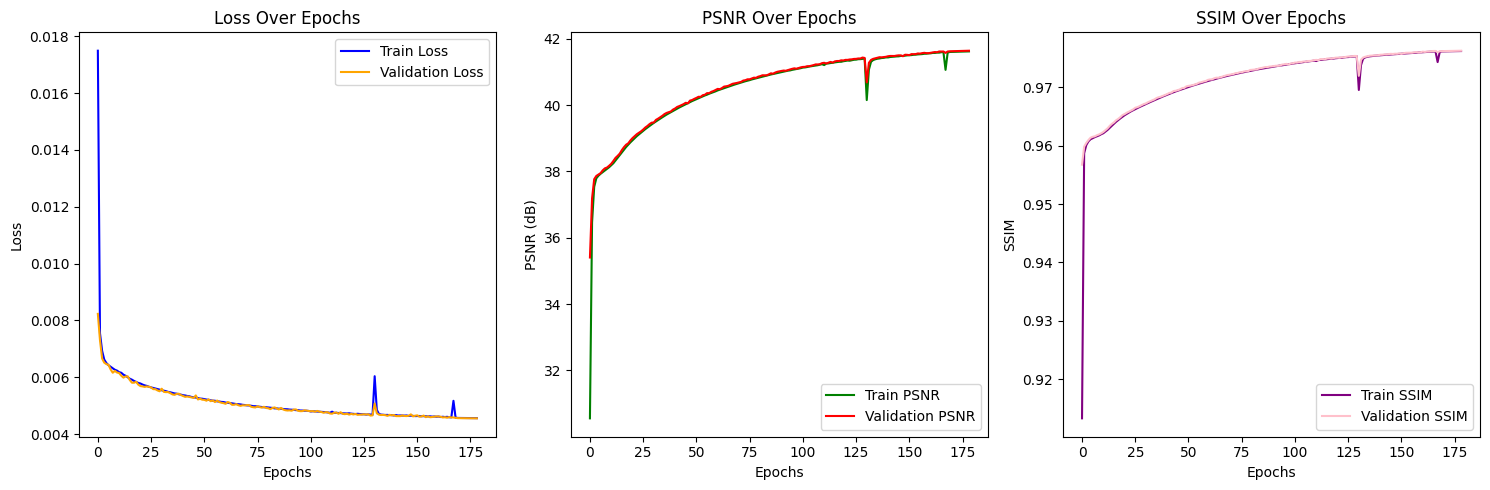

In [ ]:
import time

start_time = time.time()
history = train_model(edsr_model, trainX, trainY, valX, valY, 200, 128, True, True, 50, 40)
end_time = time.time()

# Print the time taken
print(f"Training time: {end_time - start_time:.2f} seconds")


plot_history(history)
save_model(edsr_model, 'models/edsr_model_1to0_5_deg_200epochs.keras')

In [ ]:
edsr_model = tf.keras.models.load_model('models/edsr_model_1to0_5_deg_200epochs.keras', custom_objects={'psnr': psnr, 'ssim': ssim}, safe_mode=False)

In [ ]:
test_loss, test_psnr, test_ssim, test_mse, test_mae = edsr_model.evaluate(testX, testY)

print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0047 - mae: 0.0047 - mse: 7.2210e-05 - psnr: 41.4173 - ssim: 0.9753
Test Loss: 0.004662395920604467
Test PSNR: 41.412200927734375
Test SSIM: 0.9752801656723022
Test MSE: 7.229593029478565e-05
Test MAE: 0.004662395920604467


In [ ]:
low_res_input = testX[1]
high_res_data = testY[1]
high_res_output = edsr_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


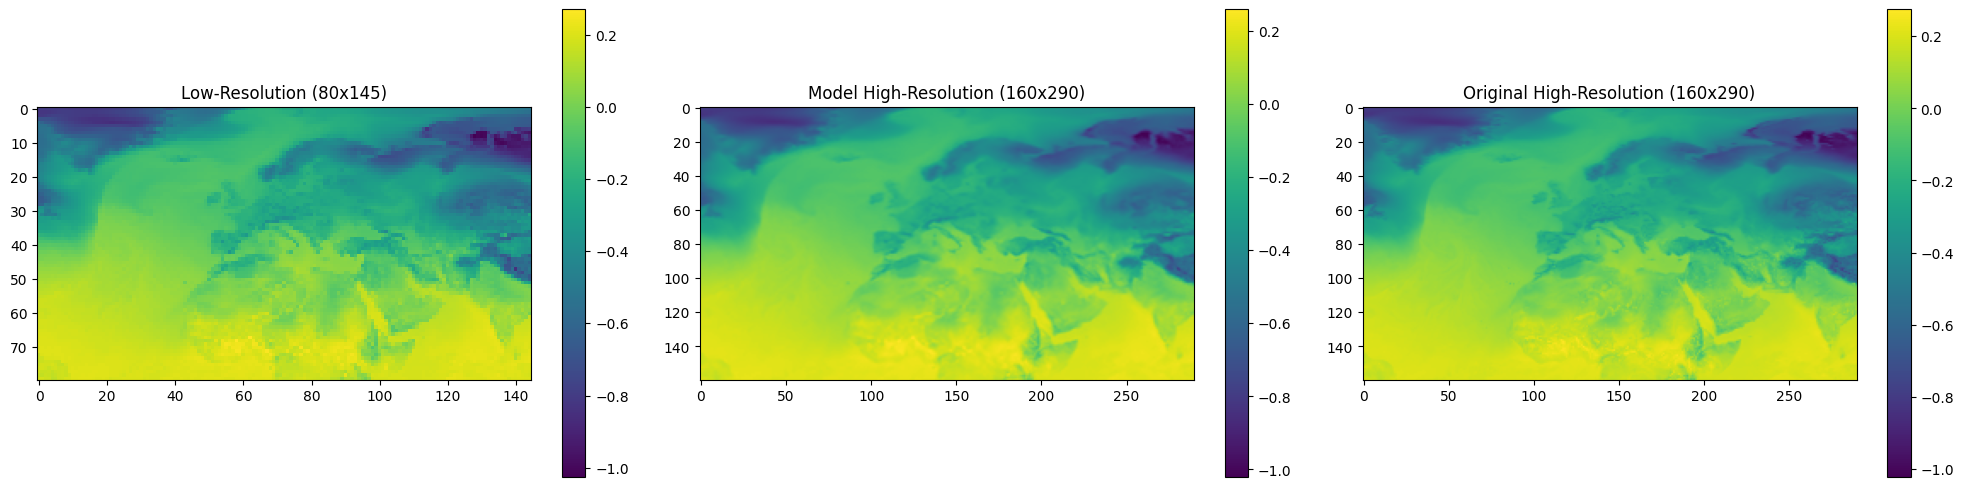

In [ ]:
plot_to_compare(low_res_input, np.squeeze(high_res_data),  np.squeeze(high_res_output), 'viridis')

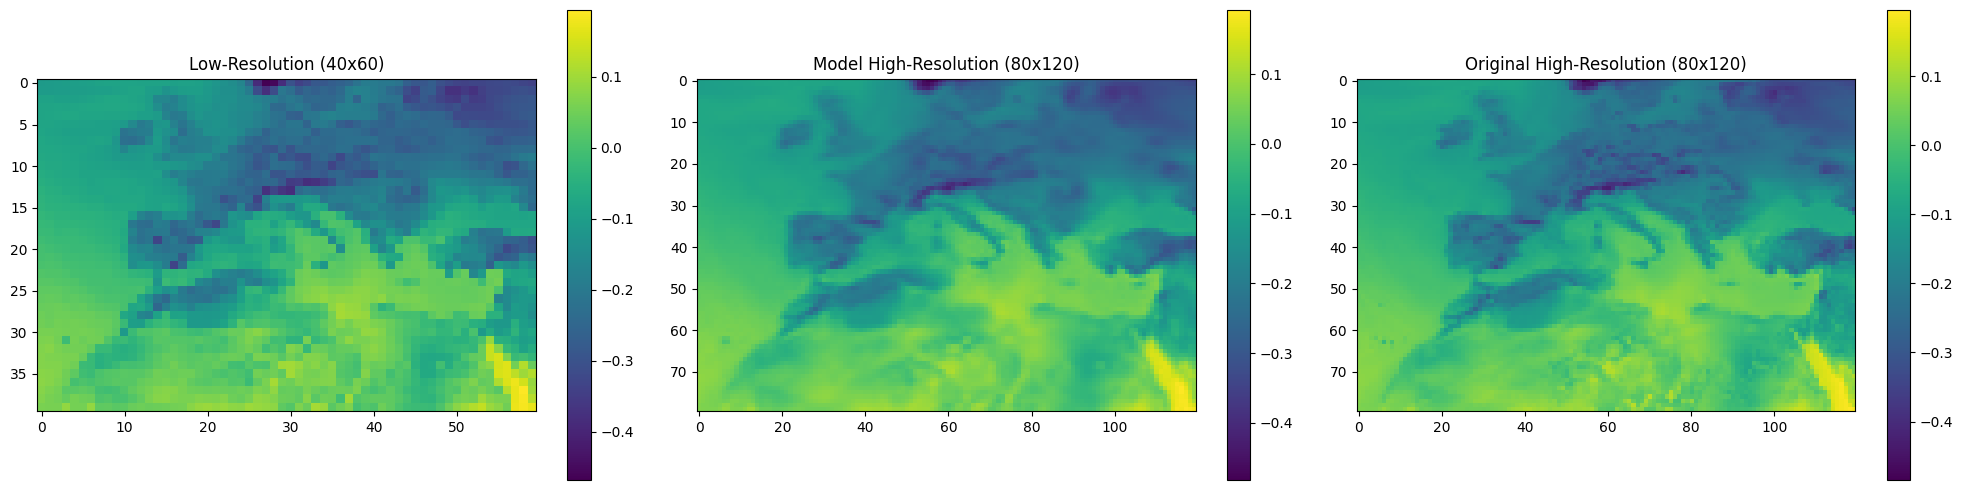

In [ ]:
plot_to_compare(low_res_input[20:60, 40:100], np.squeeze(high_res_data)[40:120, 80:200],  np.squeeze(high_res_output)[40:120, 80:200], 'viridis')

In [ ]:
# Compute per-pixel metrics
test_mse, test_mae, test_psnr, test_ssim = evaluate_per_pixel(edsr_model, testX, testY)

print("Per-pixel MSE shape:", test_mse.shape)
print("Per-pixel MAE shape:", test_mae.shape)
print("Per-pixel PSNR shape:", test_psnr.shape)
print("Per-pixel SSIM shape:", test_ssim.shape)

mean_mse = np.mean(test_mse)
mean_mae = np.mean(test_mae)
mean_psnr = np.mean(test_psnr)
mean_ssim = np.mean(test_ssim)

print("Mean Per-Pixel MSE:", mean_mse)
print("Mean Per-Pixel MAE:", mean_mae)
print("Mean Per-Pixel PSNR:", mean_psnr)
print("Mean Per-Pixel SSIM:", mean_ssim)

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Per-pixel MSE shape: (160, 290, 1)
Per-pixel MAE shape: (160, 290, 1)
Per-pixel PSNR shape: (160, 290, 1)
Per-pixel SSIM shape: (160, 290, 1)
Mean Per-Pixel MSE: 7.2295916e-05
Mean Per-Pixel MAE: 0.004662396
Mean Per-Pixel PSNR: 46.85156
Mean Per-Pixel SSIM: 0.9913928


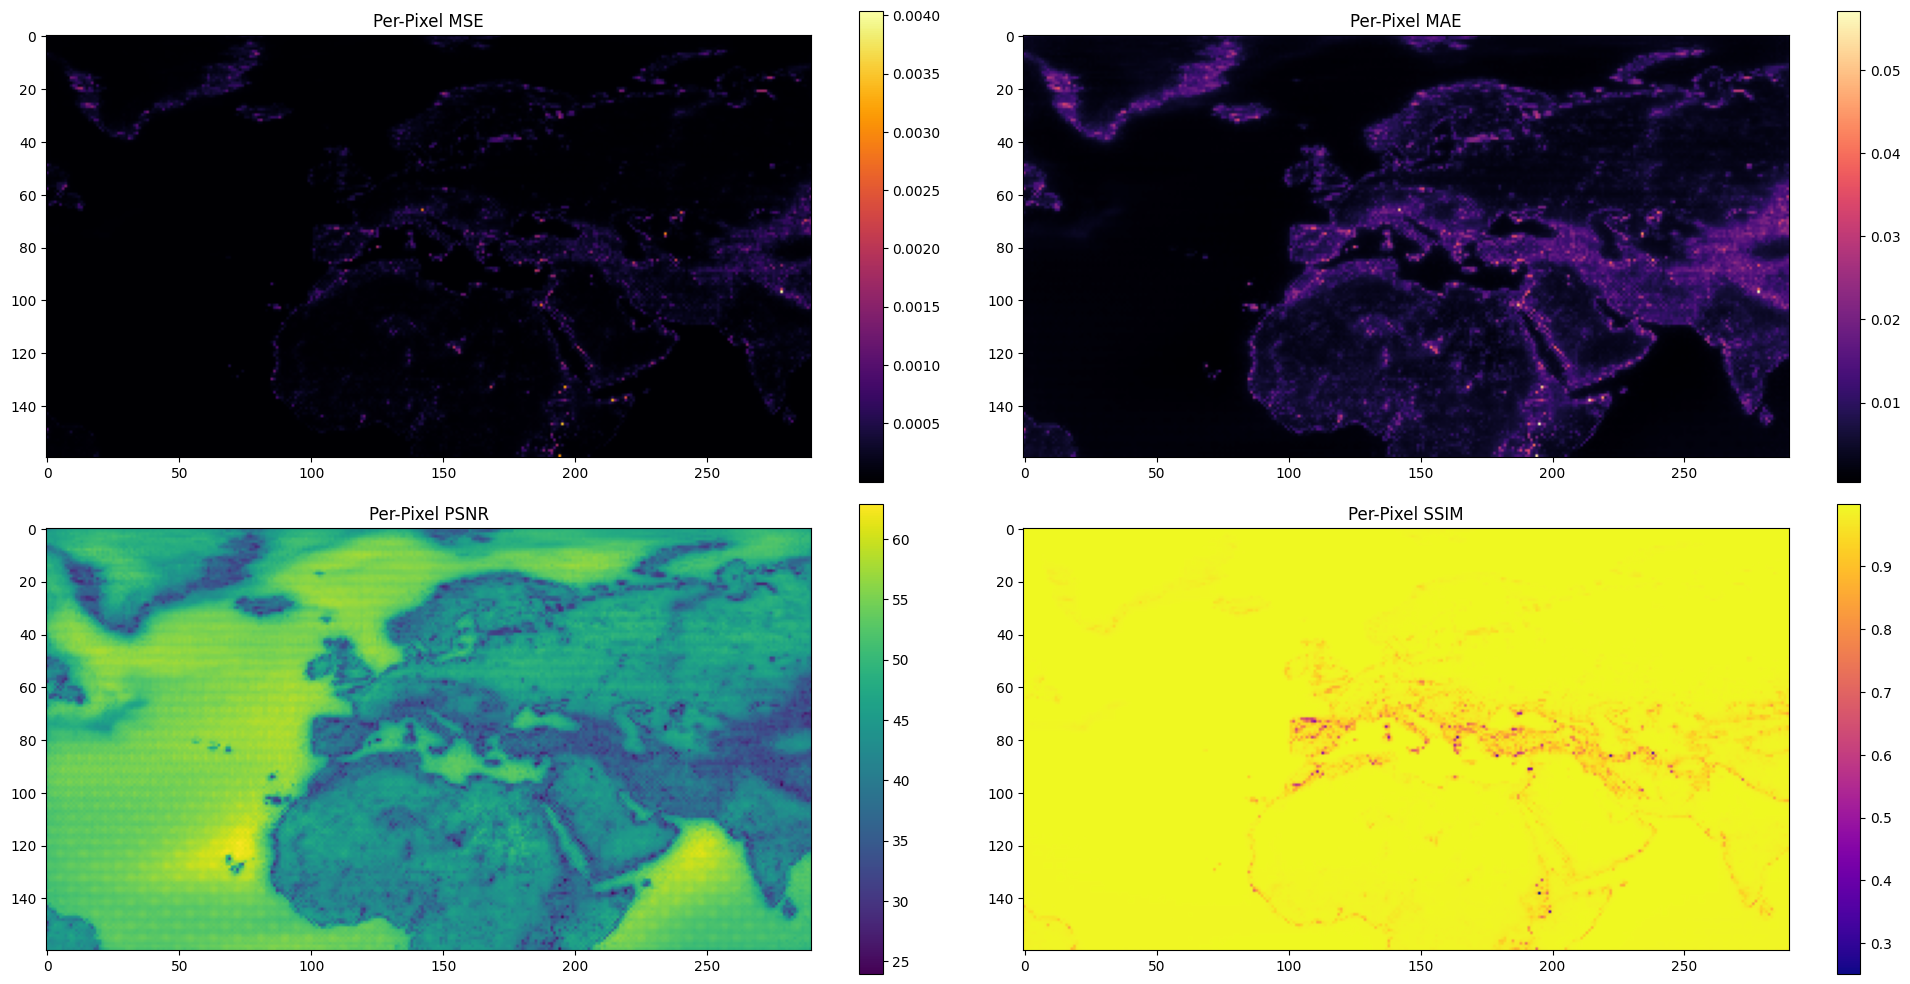

In [ ]:
# Plot results
plot_per_pixel_metrics(test_mse, test_mae, test_psnr, test_ssim)

Mean Per-Pixel Degrees MAE: 0.29959068
Max Degrees MAE: 3.6697493
Min Degrees MAE: 0.031729065


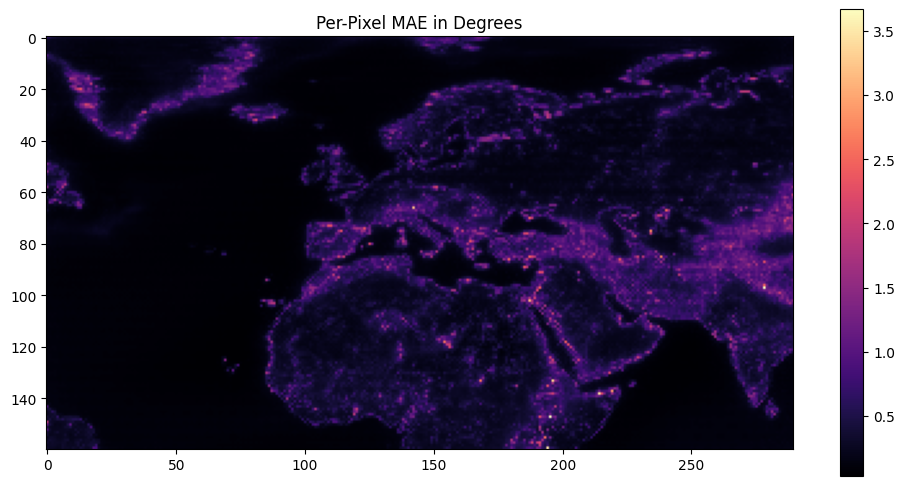

In [ ]:
degrees_mae = denormalize_mae(test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(degrees_mae))
print("Max Degrees MAE:", degrees_mae.max())
print("Min Degrees MAE:", degrees_mae.min())
plot_degrees_mae(degrees_mae)

In [ ]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(degrees_mae, '0_5'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(test_mae, '0_5'))

Mean Land-Pixels Degrees MAE: 0.45191368
Mean Land-Pixels MAE: 0.007032931


In [ ]:
print("Mean Coastline-Pixels Degrees MAE:", mean_with_coastline_mask(degrees_mae, '0_5'))
print("Mean Costline-Pixels MAE:", mean_with_coastline_mask(test_mae, '0_5'))

Mean Coastline-Pixels Degrees MAE: 0.68022335
Mean Costline-Pixels MAE: 0.010586013
